In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

In [ ]:
# I will read the CSV file containing the narrowed-down genes.
read_file = pd.read_csv('study_pruned_features.csv', index_col=False)

df = pd.DataFrame(read_file)

df = df.sort_values(by=['bdi_total'])

df.head()

In [3]:
# I will replace the BDI values with a 0.0 or 1.0.
# 0.0 corresponds to scores less than 14; 1.0 corresponds to the rest.
# A BDI of 14 or above is considered depressed; anything below is not.
# The depressed data (labelled with 1.0) will be considered anamolies.
df['bdi_total'] = np.where(df['bdi_total'].between(0, 13.0, inclusive=True), 0.0, df['bdi_total'])
df['bdi_total'] = np.where(df['bdi_total'] > 13.0, 1.0, df['bdi_total'])

In [ ]:
# I split the data up based on 0.0-values and 1.0-values.
normal = df.iloc[:98,:]
anomalous = df.iloc[98:,:]

# I split them to randomize the normal values.
normal = normal.sample(frac=1)

# Here, I put them back together.
together = [normal, anomalous]
df = pd.concat(together)

df.head()

In [5]:
# x-values are the genes; y-values are the converted BDI scores.
X = df.loc[:, 'KLRB1':'ST6GALNAC6']
y = df.loc[:,'bdi_total']

# This normalizes the data.
X = (X - X.mean()) / X.std()

In [6]:
# This will evenly split the data.
sixty_per = round(len(df)*0.6)

X_train = X.iloc[:sixty_per]
X_rest = X.iloc[sixty_per:]

y_train = y.iloc[:sixty_per]
y_rest = y.iloc[sixty_per:]

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=1)

In [7]:
y_val.value_counts()

0.0    16
1.0     9
Name: bdi_total, dtype: int64

In [8]:
y_test.value_counts()

1.0    17
0.0     8
Name: bdi_total, dtype: int64

In [9]:
# Here, I will train the model on the training set.
# I model it as a Guassian distribution.
p_train = multivariate_normal.pdf(X_train, mean=X_train.mean(), cov=X_train.std())

In [10]:
# Now, I will test the data on a cross-validation set to determine the optimal threshold, epsilon.
# Any probability below the threshold is considered an anamoly, which should correspond to the depressed cases.
p_val = multivariate_normal.pdf(X_val, mean=X_train.mean(), cov=X_train.std())

best_epsilon = 0
best_F1 = 0
F1 = 0

stepsize = (max(p_val) - min(p_val)) / 1000
it_over = np.arange(min(p_val), max(p_val), stepsize)

for epsilon in it_over:
    pred = p_val < epsilon
    F1 = metrics.f1_score(y_val, pred)
    if F1 > best_F1:
        best_F1 = F1
        best_epsilon = epsilon
        
print("The best F1-value is: " + str(best_F1))
print("The best epsilon is: " + str(best_epsilon))

The best F1-value is: 0.48484848484848486
The best epsilon is: 1.79273542779248e-48


In [11]:
# Now that we have the threshold, let's use it on the test set!
p_test = multivariate_normal.pdf(X_test, mean=X_train.mean(), cov=X_train.std())

pred_test = p_test < best_epsilon

prec_test = metrics.precision_score(y_test, pred_test)
rec_test = metrics.recall_score(y_test, pred_test)
F1_test = metrics.f1_score(y_test, pred_test)

print("The precision score is: " + str(prec_test))
print("The recall score is: " + str(rec_test))
print("The F1-value is: " + str(F1_test))

The precision score is: 0.6666666666666666
The recall score is: 0.9411764705882353
The F1-value is: 0.7804878048780487


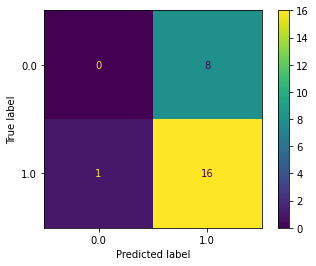

In [12]:
# Let's print the confusion matrix.
confusion = metrics.confusion_matrix(y_test, pred_test, labels=[0.0,1.0])

display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[0.0,1.0])

display.plot()